In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence

In [3]:
from snorkel.lf_helpers import *
import pickle,glob

/home/antonis/anaconda2/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [13]:
import pandas as pd
from MLutils import cohen_kappa_score

In [4]:
from MLutils import diversity_heatmap, merge_pickles_pred_dicts

In [5]:
from snorkel.models import Candidate, candidate_subclass
REGULATOR = candidate_subclass('REGULATOR', ['Chemical', 'Gene'])

In [6]:
# make sure unmapped cands are gone

In [7]:
from sqlalchemy import  any_,or_,and_

In [8]:
#create list of unmapped cands to drop
to_drop = []
for k in range(3):
    query = session.query(REGULATOR).filter(and_(REGULATOR.split==k,~REGULATOR.gold_labels.any()))
    print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
    to_drop.extend(map(lambda x: x.id,query.all()))

Adding 0 candidates from split=0 in to_drop list
Adding 0 candidates from split=1 in to_drop list
Adding 0 candidates from split=2 in to_drop list


In [9]:
# #drop unmapped cands
# query = session.query(Candidate).filter(Candidate.id.in_(to_drop))
# print query.count()
# query.delete(synchronize_session=False)
# session.commit()

# Retrieve results and pick models

In [10]:
# results_dict = merge_pickles_pred_dicts(glob.glob('ml_predictions/*.pkl'), 
#                                         f1_threshold=0.49,
#                                         list_substr=['results_dict,','minFreq=3','_'],
#                                         best_model=True,
#                                        )

In [11]:
with open("ml_predictions/good_batch_Wed0606.pickle", 'rb') as f:
    results_dict = pickle.load(f)

In [70]:
results_dict[model_name].keys()

['label_unlab_binary',
 'label_val_prob_dict',
 'label_unlab_prob_dict',
 'f1+',
 'label_test_binary',
 'label_test_prob_dict',
 'classification_report',
 'label_val_binary']

In [73]:
results_dict[model_name]['label_unlab_binary']

array([ 1,  1,  1, ...,  1,  1, -1])

In [80]:
unlab_keys0 = set(results_dict[results_dict.keys()[0]]['label_unlab_prob_dict'].keys())
#check model performance
for model_name in results_dict.keys():
    print '\n',results_dict[model_name]['f1+'], model_name
    print 'Keys matching: ',unlab_keys0 == set(results_dict[model_name]['label_unlab_prob_dict'].keys())
    result_prob = [results_dict[model_name]['label_unlab_prob_dict'][cid] for cid in sorted(results_dict[model_name]['label_unlab_prob_dict'].keys(), reverse=True)]
    result_bin = [0 if prob<=0.5 else 1 for prob in result_prob]
    print result[:10]
    print result_bin[-1110:-1000]
    
    
    print result_unlab_binary01[-1110:-1000]
    
#     print result_bin == result_unlab_binary01
    
    
    # deal with this shit later.... nice confidence there man!
#     pd.Series(result).hist()
#     plt.plot()


0.5 results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3)_LogisticRegression
Keys matching:  True
[0.5017025727036131, 0.47117860808650647, 0.47117860808650647, 0.5056995267978837, 0.5056995267978837, 0.5056995267978837, 0.5056995267978837, 0.5056995267978837, 0.5056995267978837, 0.5107918862337189]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0.5 results_dict,trim=0,R

In [ ]:
result = [results_dict[key] for model_name in sorted(results_dict.keys(), reverse=True)]

** heuristic developed for model selection **

(replaced by classifier selection.ipynb )


In [24]:
model_names = sorted(results_dict.keys())
cohens_df = pd.DataFrame(index=model_names, columns=model_names)

In [25]:
evaluate_on= 'label_val_binary'
for i,model1 in enumerate(cohens_df.index):
    for j,model2 in enumerate(cohens_df.columns):
        if i==j:
            cohens_df.iloc[i,j] = 0
        else:
            cohens_df.iloc[i,j] = cohen_kappa_score(results_dict[model1][evaluate_on],results_dict[model2][evaluate_on])

In [27]:
cohens_df.mean().sort_values().index[0]

'RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,maxsentlength=64_biLSTM'

In [36]:
# selected_models = ['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500',
#                   'lemmas,RuS,TfIdf,,stopw=english_SVC_rbf_C=500'
                  
#                   ]
# candidate_model = ['trim=5,lemmas,RuS,TfIdf,,stopw=english_LogisticRegression',]


# max([cohens_df.ix[candidate_model, selected_model].values[0] for selected_model in selected_models])

In [33]:

# def select_models(cohens_df, diversity_threshold , f1_threshold=0):
#     selected_models = [cohens_df.mean().sort_values().index[0]]
#     for candidate_model in cohens_df.mean().sort_values().index[1:]:
#         #check whether all cohens kappas are < threshold
#         if max([cohens_df.ix[candidate_model, selected_model] for selected_model in selected_models])<diversity_threshold:
#             selected_models.append(candidate_model)
#     return selected_models


In [37]:
# selected_models = select_models(cohens_df, diversity_threshold = 0.2, )

# selected_models
# # results_dict1 = {}
# # for key in selected_models:
# #     results_dict1[key]=results_dict[key]

['RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,maxsentlength=64_biLSTM',
 'trim=0,RuS,CV,bin,,stopw=english,LSA100_RandomForestClassifier']

In [41]:
diversity_heatmap(results_dict[[selected_models]], figsize=(20,20), metric=accuracy_score )

TypeError: unhashable type: 'list'

In [74]:
lowest_model_name = cohens_df.mean().idxmin()
print cohens_df.mean().idxmin() , cohens_df.mean().min()


trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500 0.4850880814909812


# Train the generative model (denoise)

In [14]:
from snorkel.annotations import LabelAnnotator

** with label generator **

In [127]:
def signal_annotator(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict1.keys():

        #hack to convert labels to -1,1....
        #TODO: switch back to unlab again
        yield model, (results_dict1[model]['label_test_prob_dict'][c.id] > 0.5)*2-1
#         yield model, (results_dict[model]['label_unlab_prob_dict'][c.id] > threshold)*2-1

#         try:
#             yield model, results_dict[model]['label_unlab_prob_dict'][c.id]
#         except:
#             yield model, 0

labeler = LabelAnnotator(label_generator=signal_annotator)

** with LFs **

In [19]:
def predictions_exist_for(c):
    """For now, skip unmapped candidates in the test set - as no predictions where generated for them."""
    if c.id in results_dict[results_dict.keys()[0]]['label_unlab_prob_dict'].keys():
        return True
    else:
        return False

In [20]:
random_cand = session.query(REGULATOR).filter(REGULATOR.split==3).all()[0]

In [21]:
predictions_exist_for(random_cand)

True

In [22]:
# results_dict['lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500'].keys()

In [23]:
# results_dict.keys()

In [61]:
from sklearn.metrics import accuracy_score

In [24]:
# diversity_heatmap(results_dict, figsize=(20,20), metric=accuracy_score )

In [25]:
# cohens_df.columns

In [26]:
results_dict.keys()

['results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3)_LogisticRegression',
 'results_dict,trim=0,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_RandomForestClassifier',
 'results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500',
 'RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,max_sent_length=64_biLSTM',
 'results_dict,RuS,CV_,bin_,minFreq=3,_stopw=english_RandomForestClassifier']

In [81]:
['RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,maxsentlength=64_biLSTM',
 'trim=0,RuS,CV,bin,,stopw=english,LSA100_RandomForestClassifier',
'RuS,CV,bin,,stopw=english_RandomForestClassifier',
]

def biLSTM(c):
    if predictions_exist_for(c):
        return -1 if results_dict['RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,max_sent_length=64_biLSTM']['label_unlab_prob_dict'][c.id]>=0.5 else 1
    else:
        return 0
        
def BOW_TFidf_upto_3grams(c):
    if predictions_exist_for(c):
        return -1 if results_dict['results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3)_LogisticRegression']['label_unlab_prob_dict'][c.id]>=0.5 else 1
    else:
        return 0
    
def BOW_CV_trimwindow0_LSA100_RF(c):
    if predictions_exist_for(c):
        return -1 if results_dict['results_dict,trim=0,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_RandomForestClassifier']['label_unlab_prob_dict'][c.id]>=0.5 else 1
    else:
        return 0
    
def BOW_CV_trimwindow5_LSA100_SVCgaussian(c):
    if predictions_exist_for(c):
        return -1 if results_dict['results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>=0.5 else 1
    else:
        return 0
    
def BOW_CV_RF(c):
    if predictions_exist_for(c):
        return -1 if results_dict['results_dict,RuS,CV_,bin_,minFreq=3,_stopw=english_RandomForestClassifier']['label_unlab_prob_dict'][c.id]>=0.5 else 1
    else:
        return 0

In [29]:
# # Pass classifier output as signals


# def mod1(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod2(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['trim=5,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod3(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod4(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['RuS,TfIdf,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        

In [30]:
# # unlab

# # Pass classifier output as signals


# def mod1(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod2(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['trim=5,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod3(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod4(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['RuS,TfIdf,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        

In [31]:
# LFs = [mod1,mod2,mod3,mod4]
LFs = [biLSTM,BOW_TFidf_upto_3grams,BOW_CV_trimwindow0_LSA100_RF,BOW_CV_trimwindow5_LSA100_SVCgaussian,BOW_CV_RF]
labeler = LabelAnnotator(lfs=LFs)

# Start denoising

In [82]:
%time L_train = labeler.apply(split=3)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 9min 59s, sys: 148 ms, total: 9min 59s
Wall time: 9min 59s


<79460x5 sparse matrix of type '<type 'numpy.int64'>'
	with 397300 stored elements in Compressed Sparse Row format>

In [83]:
# see how many LF vote on how many examples & with how many other LFs there are votes on common examples
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
biLSTM,0,1.0,1.0,0.942046
BOW_TFidf_upto_3grams,1,1.0,1.0,0.942046
BOW_CV_trimwindow0_LSA100_RF,2,1.0,1.0,0.942046
BOW_CV_trimwindow5_LSA100_SVCgaussian,3,1.0,1.0,0.942046
BOW_CV_RF,4,1.0,1.0,0.942046


In [84]:
# Find dependencies between LFs

from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.07)
len(deps)

9

In [85]:
# actual training of the gen. model
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0, deps=deps, 
)

Inferred cardinality: 2


In [86]:
train_marginals = gen_model.marginals(L_train)

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
# # plt.hist(train_marginals, bins=20)
# sns.distplot(train_marginals,bins=20)
# plt.title('Histogram of probabilistic labels (good_batch.pickle)')
# plt.show()

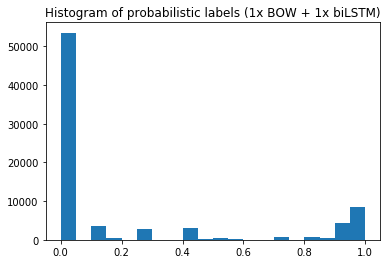

In [89]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.title('Histogram of probabilistic labels (1x BOW + 1x biLSTM)')
plt.show()

In [99]:
gen_model.weights

In [92]:
print 'But it still thinks its smart!!!! \nLOOK:'
gen_model.learned_lf_stats()

But it still thinks its smart!!!! 
LOOK:


,Accuracy,Coverage,Precision,Recall
0,0.250878,0.7685,0.250384,0.197613
1,0.941265,0.8683,0.943715,0.813916
2,0.914663,0.8484,0.912929,0.774070
3,0.951805,0.8839,0.948712,0.841828
4,0.890447,0.8416,0.890089,0.750202


## Check performance on developer set

In [100]:
# load from db gold labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<3237x1 sparse matrix of type '<type 'numpy.int64'>'
	with 3237 stored elements in Compressed Sparse Row format>

In [101]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [103]:
L_dev

<3237x5 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [102]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/home/antonis/snorkel/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
biLSTM,0,0.0,0.0,0.0,0,0,0,0,NaN,0.247011
BOW_TFidf_upto_3grams,1,0.0,0.0,0.0,0,0,0,0,NaN,0.939844
BOW_CV_trimwindow0_LSA100_RF,2,0.0,0.0,0.0,0,0,0,0,NaN,0.913698
BOW_CV_trimwindow5_LSA100_SVCgaussian,3,0.0,0.0,0.0,0,0,0,0,NaN,0.945980
BOW_CV_RF,4,0.0,0.0,0.0,0,0,0,0,NaN,0.886893


In [ ]:
# Yes, because my LFs vote only on the unlabeled set results!!!

## save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on

In [62]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 79460 marginals


In [175]:
from sklearn.metrics import precision_score, accuracy_score

In [173]:
results_dict1['trim=5,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_binary']

['label_unlab_binary',
 'label_val_prob_dict',
 'label_unlab_prob_dict',
 'f1+',
 'label_val_binary',
 'label_test_prob_dict',
 'classification_report',
 'label_test_binary']

In [176]:
mod1pred = results_dict1['trim=5,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_binary']
mod2pred = results_dict1['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_binary']
print precision_score(mod1pred,mod2pred)
print accuracy_score(mod1pred,mod2pred)
print cohen_kappa_score(mod1pred,mod2pred)

0.6599743510370141
0.7940850742511956
0.5008445741717802


# ~~ 

In [47]:
L_test = labeler.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%



In [49]:
# load from db gold labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<13350x1 sparse matrix of type '<type 'numpy.int64'>'
	with 5781 stored elements in Compressed Sparse Row format>

In [50]:
_ = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.259
Neg. class accuracy: 0.975
Precision            0.57
Recall               0.259
F1                   0.356
----------------------------------------
TP: 388 | FP: 293 | TN: 11557 | FN: 1112



In [51]:
L_test.lf_stats(session, L_gold_test, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
dummy,0,1.000000,0.433034,0.128764,0,0,1500,4281,0.740529,0.936173
LogisticRegression,1,0.433034,0.433034,0.128764,683,563,817,3718,0.761287,0.893057
SVC_linear,2,0.433034,0.433034,0.128764,594,592,906,3689,0.740875,0.888321
SVC_rbf_C100,3,0.433034,0.433034,0.128764,606,500,894,3781,0.758865,0.893826
SVC_rbf_C500,4,0.433034,0.433034,0.128764,625,484,875,3797,0.764920,0.897841
SVC_rbf_C1000,5,0.433034,0.433034,0.128764,577,480,923,3801,0.757308,0.899282
